# E6C : 6-circle diffractometer example

The 6-circle diffractometer can be considered as a 4-circle
diffractometer with two additional rotations that rotate the 
sample and detector separately about the $\vec z$ axis.

![Schematic of a 6-circle diffractometer](resources/4S+2D-labeled.png)

----

Note:  This example is available as a
[Jupyter notebook](https://jupyter.org/) from the *hklpy* source
code website: https://github.com/bluesky/hklpy/tree/main/examples

## Setup the *E6C* diffractometer in *hklpy*

In _hkl_ *E6C* geometry (https://people.debian.org/~picca/hkl/hkl.html#orge5e0490):

* xrays incident on the $\vec{x}$ direction (1, 0, 0)

axis  | moves    | rotation axis  | vector
---   | :---      | :---:                |:---
mu    | sample   | $\vec{z}$            | `[0 0 1]`
omega | sample   | $-\vec{y}$           | `[0 -1 0]`
chi   | sample   | $\vec{x}$            | `[1 0 0]`
phi   | sample   | $-\vec{y}$           | `[0 -1 0]`
gamma | detector | $\vec{z}$            | `[0 0 1]`
delta | detector | $-\vec{y}$           | `[0 -1 0]`


## Define _this_ diffractometer

Create a Python class that specifies the names of the 
real-space positioners.  We call it `SixCircle` here but that
choice is arbitrary.  Pick any valid Python name not already in use.
The convention is to start Python class names with a capital letter
and use CamelCase to mark word starts.

The argument to the `SixCircle` class tells which *hklpy* base
class will be used.  This sets the geometry.  (The class we show
here could be replaced entirely with `hkl.geometries.SimulatedE6C`
but we choose to show here the complete steps to produce that class.)
The [*hklpy*
documentation](https://blueskyproject.io/hklpy/master/geometries.html)
provides a complete list of diffractometer geometries.


In *hklpy*, the reciprocal-space axes
are known as `pseudo` positioners while the real-space axes
are known as `real` positioners.  For the real positioners,
it is possible to use different names than the canonical names
used internally by the *hkl* library.  That is not covered here.

Note: The keyword argument `kind="hinted"` is an indication
that this signal may be plotted.

This `SixCircle()` class example uses simulated motors.  See the drop-down
for an example how to use EPICS motors.

<details>
    <summary><tt>SixCircle()</tt> class using EPICS motors</summary>


```python

from hkl import E6C
from ophyd import EpicsMotor, PseudoSingle
from ophyd import Component as Cpt

class SixCircle(E6C):
    """
    Our 6-circle.  Eulerian.
    """
    # the reciprocal axes are called "pseudo" in hklpy
    h = Cpt(PseudoSingle, '', kind="hinted")
    k = Cpt(PseudoSingle, '', kind="hinted")
    l = Cpt(PseudoSingle, '', kind="hinted")

    # the motor axes are called "real" in hklpy
    mu = Cpt(EpicsMotor, "pv_prefix:m42", kind="hinted")
    omega = Cpt(EpicsMotor, "pv_prefix:m41", kind="hinted")
    chi = Cpt(EpicsMotor, "pv_prefix:m22", kind="hinted")
    phi = Cpt(EpicsMotor, "pv_prefix:m35", kind="hinted")
    gamma = Cpt(EpicsMotor, "pv_prefix:m7", kind="hinted")
    delta = Cpt(EpicsMotor, "pv_prefix:m8", kind="hinted")
```

</details>

In [2]:
from hkl import E6C, SimMixin
from ophyd import SoftPositioner
from ophyd import Component as Cpt

class SixCircle(SimMixin, E6C):
    """
    Our 6-circle.  Eulerian.
    """
    # the reciprocal axes are defined by SimMixin

    mu = Cpt(SoftPositioner, kind="hinted", limits=(-180, 180), init_pos=0)
    omega = Cpt(SoftPositioner, kind="hinted", limits=(-180, 180), init_pos=0)
    chi = Cpt(SoftPositioner, kind="hinted", limits=(-180, 180), init_pos=0)
    phi = Cpt(SoftPositioner, kind="hinted", limits=(-180, 180), init_pos=0)
    gamma = Cpt(SoftPositioner, kind="hinted", limits=(-180, 180), init_pos=0)
    delta = Cpt(SoftPositioner, kind="hinted", limits=(-180, 180), init_pos=0)

Create the Python diffractometer object (`sixc`) using the `SixCircle()` class.  By convention, the `name` keyword is the same as the object name.

In [3]:
sixc = SixCircle("", name="sixc")

## Add a sample with a crystal structure

In [4]:
from hkl import Lattice
from hkl import SI_LATTICE_PARAMETER

# add the sample to the calculation engine
a0 = SI_LATTICE_PARAMETER
sixc.calc.new_sample(
    "silicon",
    lattice=Lattice(a=a0, b=a0, c=a0, alpha=90, beta=90, gamma=90)
    )

HklSample(name='silicon', lattice=LatticeTuple(a=5.431020511, b=5.431020511, c=5.431020511, alpha=90.0, beta=90.0, gamma=90.0), ux=Parameter(name='None (internally: ux)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uy=Parameter(name='None (internally: uy)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uz=Parameter(name='None (internally: uz)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), U=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), UB=array([[ 1.15690694e+00, -7.08401189e-17, -7.08401189e-17],
       [ 0.00000000e+00,  1.15690694e+00, -7.08401189e-17],
       [ 0.00000000e+00,  0.00000000e+00,  1.15690694e+00]]), reflections=[])

## Setup the UB orientation matrix using *hklpy*

Define the crystal's orientation on the diffractometer using 
the 2-reflection method described by [Busing & Levy, Acta Cryst 22 (1967) 457](https://www.psi.ch/sites/default/files/import/sinq/zebra/PracticalsEN/1967-Busing-Levy-3-4-circle-Acta22.pdf).

### Set the same X-ray wavelength for both reflections, by setting the diffractometer energy

In [5]:
from hkl import A_KEV
sixc.energy.put(A_KEV / 1.54)  # (8.0509 keV)

### Find the first reflection and identify its Miller indices: (_hkl_)

In [6]:
r1 = sixc.calc.sample.add_reflection(
    4, 0, 0,
    position=sixc.calc.Position(
        delta=69.0966,
        omega=-145.451,
        chi=0,
        phi=0,
        mu=0,
        gamma=0,
    )
)

### Find the second reflection

In [7]:
r2 = sixc.calc.sample.add_reflection(
    0, 4, 0,
    position=sixc.calc.Position(
        delta=69.0966,
        omega=-145.451,
        chi=90,
        phi=0,
        mu=0,
        gamma=0,
    )
)

### Compute the *UB* orientation matrix

The `add_reflection()` method uses the current wavelength at the time it is called.  (To add reflections at different wavelengths, change the wavelength _before_ calling `add_reflection()` each time.)  The `compute_UB()` method returns the computed **UB** matrix.  Ignore it here.

In [8]:
sixc.calc.sample.compute_UB(r1, r2)

array([[-1.41342846e-05, -1.41342846e-05, -1.15690694e+00],
       [ 0.00000000e+00, -1.15690694e+00,  1.41342846e-05],
       [-1.15690694e+00,  1.72682934e-10,  1.41342846e-05]])

## Report what we have setup

In [9]:
sixc.pa()

===================== ========================================================================================================
term                  value                                                                                                   
===================== ========================================================================================================
diffractometer        sixc                                                                                                    
geometry              E6C                                                                                                     
class                 SixCircle                                                                                               
energy (keV)          8.05092                                                                                                 
wavelength (angstrom) 1.54000                                                                                  

## Check the orientation matrix

Perform checks with _forward_ (hkl to angle) and
_inverse_ (angle to hkl) computations to verify the diffractometer
will move to the same positions where the reflections were identified.

### Constrain the motors to limited ranges

* allow for slight roundoff errors
* keep `delta` in the positive range
* keep `omega` in the negative range
* keep `gamma`, `mu`, & `phi` fixed at zero

First, we apply constraints directly to the `calc`-level support.

In [10]:
sixc.calc["delta"].limits = (-0.001, 180)
sixc.calc["omega"].limits = (-180, 0.001)

for nm in "gamma mu phi".split():
    getattr(sixc, nm).move(0)
    sixc.calc[nm].fit = False
    sixc.calc[nm].value = 0
    sixc.calc[nm].limits = (0, 0)
sixc.engine.mode = "constant_phi_vertical"
sixc.show_constraints()

===== ========= ========== ===== =====
axis  low_limit high_limit value fit  
===== ========= ========== ===== =====
mu    0.0       0.0        0.0   False
omega -180.0    0.001      0.0   True 
chi   -180.0    180.0      0.0   True 
phi   0.0       0.0        0.0   False
gamma 0.0       0.0        0.0   False
delta -0.001    180.0      0.0   True 
===== ========= ========== ===== =====



Next, we show how to use additional methods of `Diffractometer()` that support *undo* and *reset* features for applied constraints.  The support is based on a *stack* (a Python list).  A set of constraints is added (`apply_constraints()`) or removed (`undo_last_constraints()`) from the stack.  Or, the stack can be cleared (`reset_constraints()`).

method | what happens
:--- | :---
`apply_constraints()` | Add a set of constraints and use them
`undo_last_constraints()` | Remove the most-recent set of constraints and restore the previous one from the stack.
`reset_constraints()` | Set constraints back to initial settings.
`show_constraints()` | Print the current constraints in a table.

A set of constraints is a Python dictionary that uses the real positioner names (the motors) as the keys.  Only those constraints with changes need be added to the dictionary but it is permissable to describe all the real positioners.  Each value in the dictionary is a [`hkl.diffract.Constraint`](https://blueskyproject.io/hklpy/diffract.html#hkl.diffract.Constraint), where the values are specified in this order: `low_limit, high_limit, value, fit`.

`fit` | constraint
:--- | :---
`True` | Only accept solutions with positions between `low_limit` and `high_limit`.
`False` | Do not allow this positioner to be adjusted and fix its position to `value`.

Apply new constraints using the [`applyConstraints()`](https://blueskyproject.io/hklpy/diffract.html#hkl.diffract.Diffractometer.apply_constraints) method.  These *add* to the existing constraints, as shown in the table.

In [11]:
from hkl import Constraint
sixc.apply_constraints(
    {
        "delta": Constraint(-0.001, 90, 0, True),
        "chi": Constraint(-90, 90, 0, True),
    }
)
sixc.show_constraints()

===== ========= ========== ===== =====
axis  low_limit high_limit value fit  
===== ========= ========== ===== =====
mu    0.0       0.0        0.0   False
omega -180.0    0.001      0.0   True 
chi   -90.0     90.0       0.0   True 
phi   0.0       0.0        0.0   False
gamma 0.0       0.0        0.0   False
delta -0.001    90.0       0.0   True 
===== ========= ========== ===== =====



Then remove (undo) those new additions.

In [12]:
sixc.undo_last_constraints()
sixc.show_constraints()

===== ========= ========== ===== =====
axis  low_limit high_limit value fit  
===== ========= ========== ===== =====
mu    0.0       0.0        0.0   False
omega -180.0    0.001      0.0   True 
chi   -180.0    180.0      0.0   True 
phi   0.0       0.0        0.0   False
gamma 0.0       0.0        0.0   False
delta -0.001    180.0      0.0   True 
===== ========= ========== ===== =====



### (400) reflection test

1. Check the `inverse` (angles -> (_hkl_)) computation.
1. Check the `forward` ((_hkl_) -> angles) computation.

#### Check the inverse calculation: (400)

To calculate the (_hkl_) corresponding to a given set of motor angles,
call `fourc.inverse((h, k, l))`.  Note the second set of parentheses needed by this function.

The values are specified, without names, in the order specified
by `fourc.calc.physical_axis_names`.

In [13]:
print("axis names:", sixc.calc.physical_axis_names)

axis names: ['mu', 'omega', 'chi', 'phi', 'gamma', 'delta']


Now, proceed with the inverse calculation.

In [14]:
sol = sixc.inverse((0, -145.451, 0, 0, 0, 69.0966))
print(f"(4 0 0) ? {sol.h:.2f} {sol.k:.2f} {sol.l:.2f}")

(4 0 0) ? 4.00 0.00 0.00


#### Check the forward calculation: (400)

Compute the angles necessary to position the diffractometer
for the given reflection.

Note that for the forward computation, more than one set of angles may be used to reach the same crystal reflection.  This test will report the *default* selection.  The *default* selection (which may be changed through methods described in the `hkl.calc` module) is the first solution.

function | returns
--- | ---
`sixc.forward()` | The *default* solution
`sixc.calc.forward()` | List of all allowed solutions.

In [15]:
sol = sixc.forward((4, 0, 0))
print(
    "(400) :", 
    f"tth={sol.delta:.4f}", 
    f"omega={sol.omega:.4f}", 
    f"chi={sol.chi:.4f}", 
    f"phi={sol.phi:.4f}",
    f"mu={sol.mu:.4f}",
    f"gamma={sol.gamma:.4f}",
    )

(400) : tth=69.0982 omega=-145.4502 chi=0.0000 phi=0.0000 mu=0.0000 gamma=0.0000


### (040) reflection test

Repeat the `inverse` and `forward` calculations for the
second orientation reflection.

### Check the inverse calculation: (040)

In [16]:
sol = sixc.inverse((0, -145.451, 90, 0, 0, 69.0966))
print(f"(0 4 0) ? {sol.h:.2f} {sol.k:.2f} {sol.l:.2f}")

(0 4 0) ? 0.00 4.00 0.00


### Check the forward calculation: (040)

In [17]:
sol = sixc.forward((0, 4, 0))
print(
    "(040) :", 
    f"tth={sol.delta:.4f}", 
    f"omega={sol.omega:.4f}", 
    f"chi={sol.chi:.4f}", 
    f"phi={sol.phi:.4f}",
    f"mu={sol.mu:.4f}",
    f"gamma={sol.gamma:.4f}",
    )

(040) : tth=69.0982 omega=-145.4502 chi=90.0000 phi=0.0000 mu=0.0000 gamma=0.0000


## Scan in reciprocal space using Bluesky

To scan with Bluesky, we need more setup.

In [18]:
%matplotlib inline

from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
from bluesky.magics import BlueskyMagics
import bluesky.plans as bp
import bluesky.plan_stubs as bps
import databroker
from IPython import get_ipython
import matplotlib.pyplot as plt

plt.ion()

bec = BestEffortCallback()
db = databroker.temp().v1
sd = SupplementalData()

get_ipython().register_magics(BlueskyMagics)

RE = RunEngine({})
RE.md = {}
RE.preprocessors.append(sd)
RE.subscribe(db.insert)
RE.subscribe(bec)

1

### (_h00_) scan near (400)

In this example, we have no detector.  Still, we add the diffractometer
object in the detector list so that the _hkl_ and motor positions will appear
as columns in the table.



Transient Scan ID: 1     Time: 2021-07-21 16:25:09
Persistent Unique Scan ID: '6e9c9699-d3f6-47fb-b7b3-5aa8a692dee7'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |     sixc_h |     sixc_k |     sixc_l |    sixc_mu | sixc_omega |   sixc_chi |   sixc_phi | sixc_gamma | sixc_delta |
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 16:25:10.0 |      3.900 |     -0.000 |     -0.000 |      0.000 |   -146.431 |     -0.000 |      0.000 |      0.000 |     67.137 |
|         2 | 16:25:10.9 |      3.950 |     -0.000 |     -0.000 |      0.000 |   -145.942 |      0.000 |      0.000 |      0.000 |     68.115 |
|         3 | 16:25:12.0 |      4.000 |      0.000 |      0.000 |      0.000 |   -145.450 |      0.000 |      0.000 |      0.000 |     69.0

/home/prjemian/.local/lib/python3.8/site-packages/bluesky/callbacks/fitting.py:165: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


('6e9c9699-d3f6-47fb-b7b3-5aa8a692dee7',)

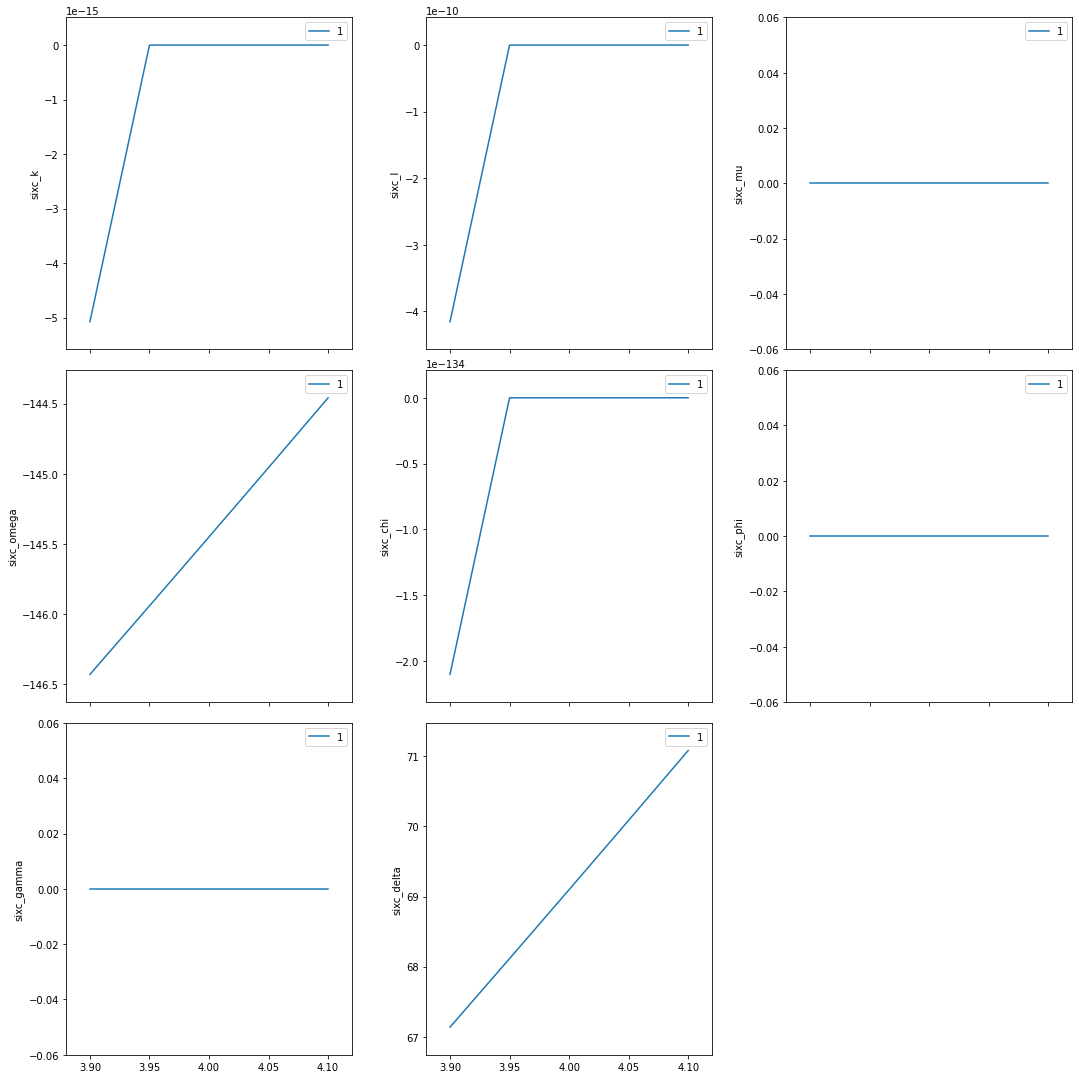

In [19]:
RE(bp.scan([sixc], sixc.h, 3.9, 4.1, 5))

### chi scan from (400) to (040)

If we do this with $\omega=-145.451$ and $\delta=69.0966$, this will be a scan between the two orientation reflections.

Use `%mov` (IPython *magic* command) to move both motors at the same time.

possible modes: ['bissector_vertical', 'constant_omega_vertical', 'constant_chi_vertical', 'constant_phi_vertical', 'lifting_detector_phi', 'lifting_detector_omega', 'lifting_detector_mu', 'double_diffraction_vertical', 'bissector_horizontal', 'double_diffraction_horizontal', 'psi_constant_vertical', 'psi_constant_horizontal', 'constant_mu_horizontal']
chosen mode: constant_phi_vertical


Transient Scan ID: 2     Time: 2021-07-21 16:25:16
Persistent Unique Scan ID: '67162700-b9ab-493c-a808-b663bd13eecc'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |   sixc_chi |     sixc_h |     sixc_k |     sixc_l |    sixc_mu | sixc_omega |   sixc_phi | sixc_gamma | sixc_delta |
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 16:25:16.8 |      0.000

('67162700-b9ab-493c-a808-b663bd13eecc',)

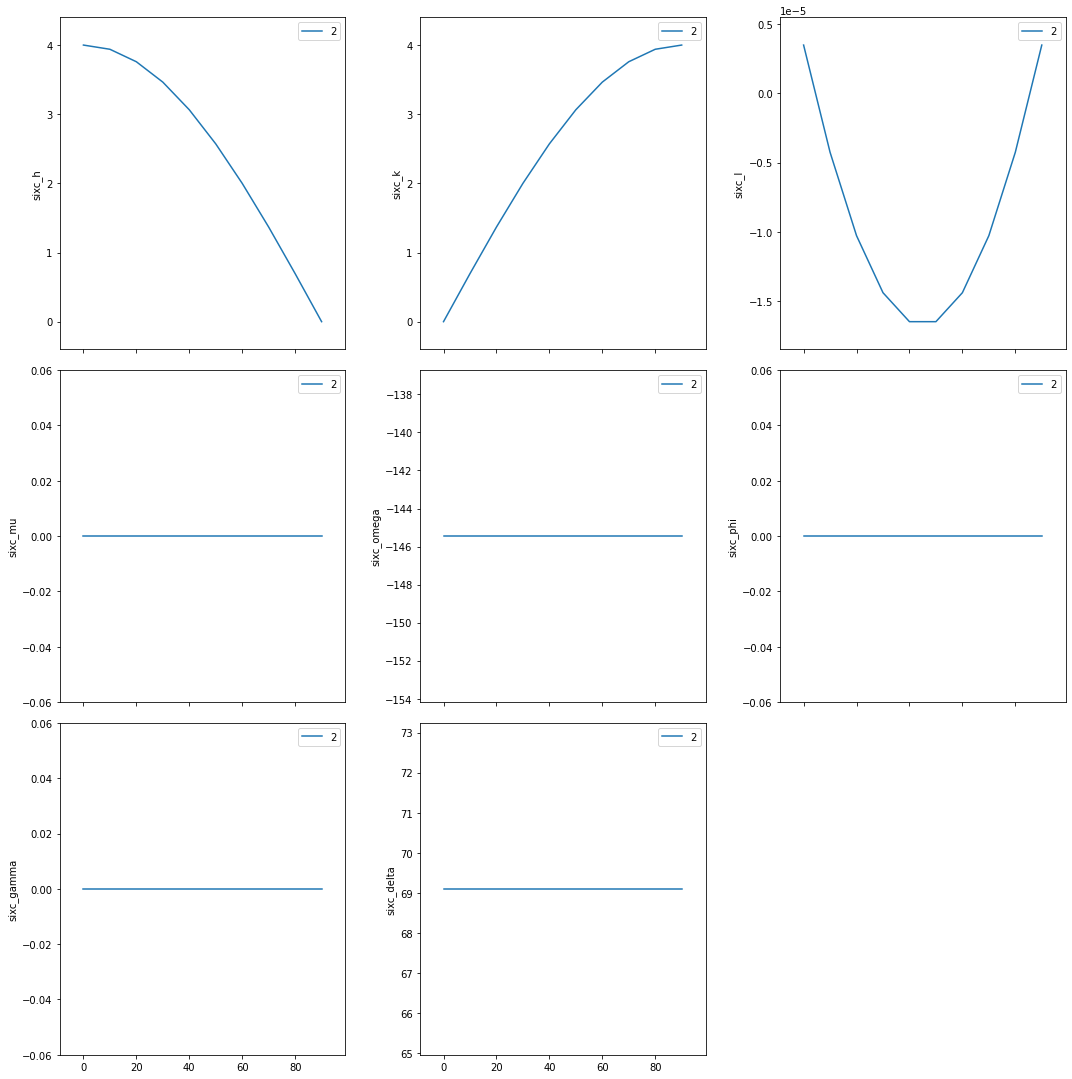

In [20]:
print("possible modes:", sixc.calc.engine.modes)
print("chosen mode:", sixc.calc.engine.mode)

# same as orientation reflections
%mov sixc.omega -145.4500 sixc.delta 69.0985

RE(bp.scan([sixc], sixc.chi, 0, 90, 10))

### (_0k0_) scan near (040)



Transient Scan ID: 3     Time: 2021-07-21 16:25:29
Persistent Unique Scan ID: '5b542f10-4b6f-4f56-ac0a-4a71ce67a6e7'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |     sixc_k |     sixc_h |     sixc_l |    sixc_mu | sixc_omega |   sixc_chi |   sixc_phi | sixc_gamma | sixc_delta |
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 16:25:29.2 |      3.900 |      4.100 |     -0.000 |      0.000 |   -126.652 |     43.568 |      0.000 |      0.000 |    106.695 |
|         2 | 16:25:30.1 |      3.950 |      4.100 |     -0.000 |      0.000 |   -126.179 |     43.933 |      0.000 |      0.000 |    107.641 |
|         3 | 16:25:31.1 |      4.000 |      4.100 |     -0.000 |      0.000 |   -125.697 |     44.293 |      0.000 |      0.000 |    108.6

('5b542f10-4b6f-4f56-ac0a-4a71ce67a6e7',)

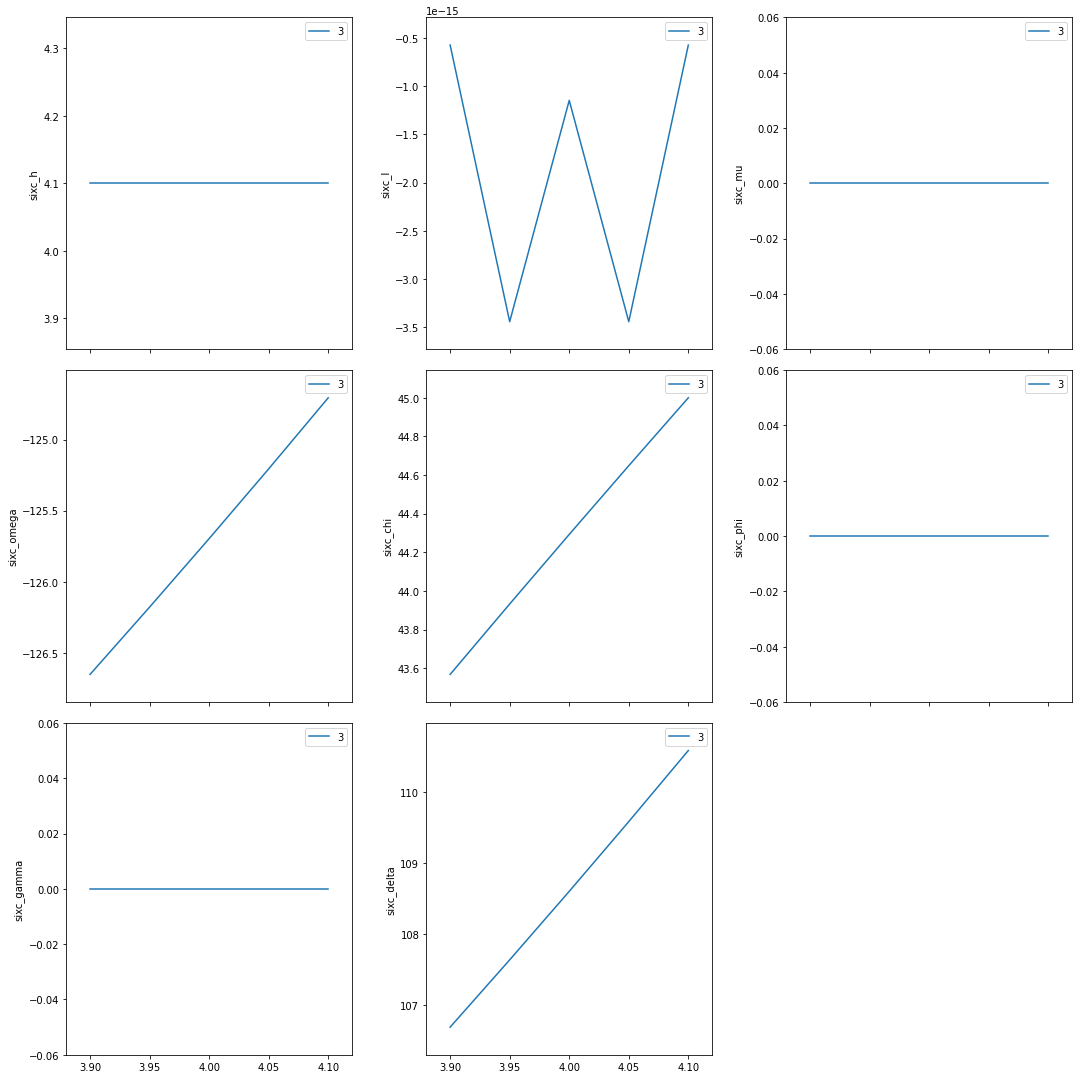

In [21]:
RE(bp.scan([sixc], sixc.k, 3.9, 4.1, 5))

### (_hk0_) scan near (440)



Transient Scan ID: 4     Time: 2021-07-21 16:25:35
Persistent Unique Scan ID: '8069c24b-c160-4951-8935-873b544020ff'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |     sixc_h |     sixc_k |     sixc_l |    sixc_mu | sixc_omega |   sixc_chi |   sixc_phi | sixc_gamma | sixc_delta |
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 16:25:35.9 |      3.900 |      4.100 |     -0.000 |      0.000 |   -126.652 |     46.432 |      0.000 |      0.000 |    106.695 |
|         2 | 16:25:36.6 |      3.950 |      4.050 |     -0.000 |      0.000 |   -126.670 |     45.716 |      0.000 |      0.000 |    106.659 |
|         3 | 16:25:37.4 |      4.000 |      4.000 |     -0.000 |      0.000 |   -126.676 |     45.000 |      0.000 |      0.000 |    106.6

('8069c24b-c160-4951-8935-873b544020ff',)

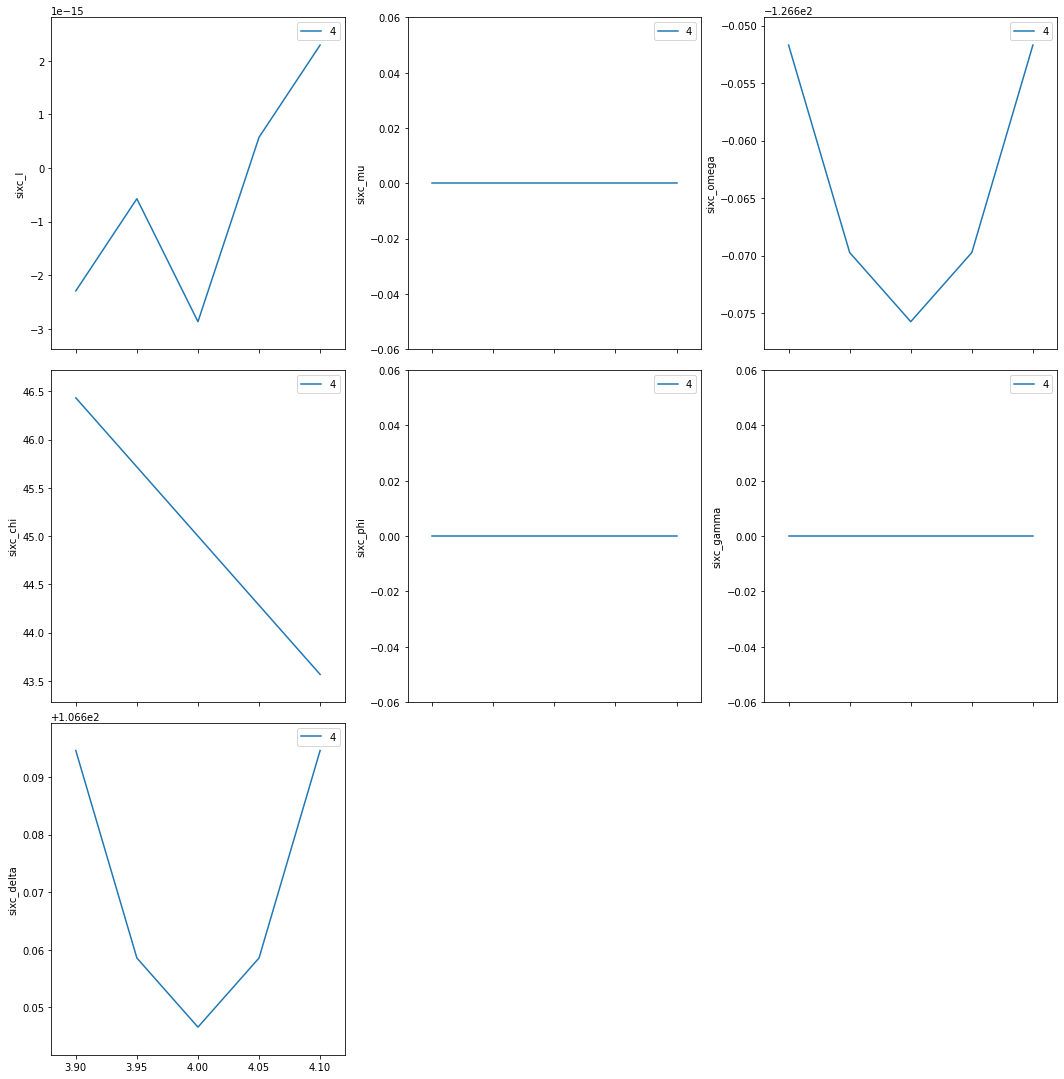

In [22]:
RE(bp.scan([sixc], sixc.h, 3.9, 4.1, sixc.k, 4.1, 3.9, 5))

Move to the (_440_) reflection.

In [23]:
sixc.move((4,4,0))
print(f"{sixc.position = }")

sixc.position = SixCirclePseudoPos(h=4.0, k=4.000000000000002, l=-5.735944501465638e-16)


Repeat the same scan about the (_440_) but use _relative_ positions.



Transient Scan ID: 5     Time: 2021-07-21 16:25:40
Persistent Unique Scan ID: 'bff1dfad-8c75-4ce7-8732-913b0c16e103'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |     sixc_h |     sixc_k |     sixc_l |    sixc_mu | sixc_omega |   sixc_chi |   sixc_phi | sixc_gamma | sixc_delta |
+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 16:25:41.1 |      3.900 |      3.900 |     -0.000 |      0.000 |   -128.558 |     45.000 |      0.000 |      0.000 |    102.882 |
|         2 | 16:25:41.8 |      3.950 |      3.950 |     -0.000 |      0.000 |   -127.627 |     45.000 |      0.000 |      0.000 |    104.744 |
|         3 | 16:25:42.5 |      4.000 |      4.000 |     -0.000 |      0.000 |   -126.676 |     45.000 |      0.000 |      0.000 |    106.6

('bff1dfad-8c75-4ce7-8732-913b0c16e103',)

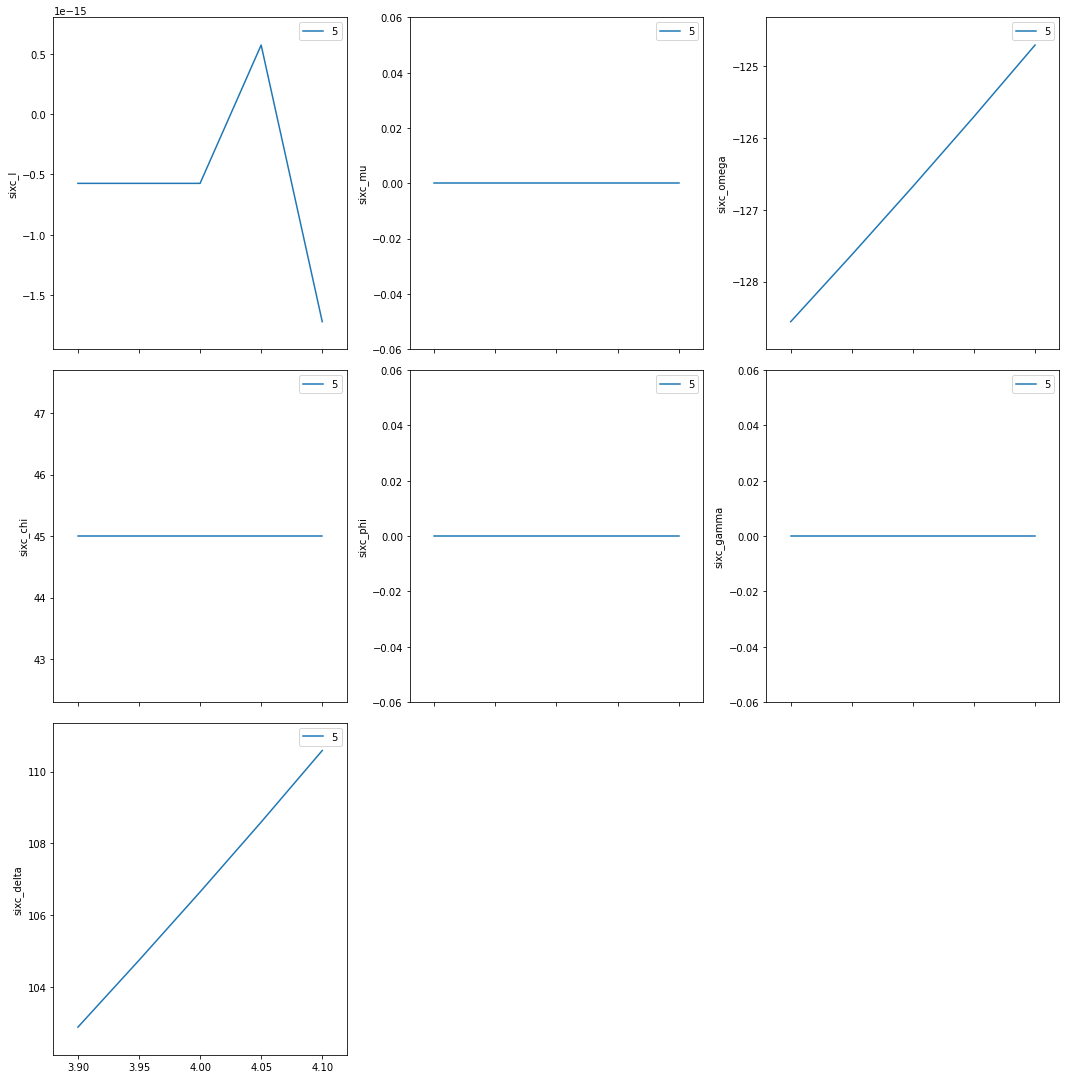

In [24]:
RE(bp.rel_scan([sixc], sixc.h, -0.1, 0.1, sixc.k, -0.1, 0.1, 5))